In [1]:
from tqdm.notebook import tqdm as tqdm
from keras.applications.inception_v3 import InceptionV3
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.models import Sequential, Model
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam, RMSprop 
from Dental_Tool.Data_processing import make_generator
from sklearn.utils import shuffle
# from keras.optimizers import RMSprop
import keras.backend as K


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import collections
import json
import cv2
import os

Using TensorFlow backend.


In [2]:
dir_path = "10_20200901_Original"

mapping_data = json.load(open(f"Dental_Data/PBL/{dir_path}/mapping.json", "r"))
filter_data = { path: max(list(map(int, state))) for path, state in mapping_data.items() if max(list(map(int, state))) >= 0 }

def json_2_dataframe_PBL(dataframe, data):
        data_dict, counter = collections.OrderedDict(), 0
        
        multi_root = [1, 2, 3, 14, 15, 16, 17, 18, 19, 30, 31, 32]
        less_data  = [1, 16, 17, 32]
        
        for path, state in tqdm(data.items()):
                item = { "Path": path, "State": state, "Class": state-1 if state > 1 else 0  }
                path_split = path.split("_")
                item["tooth_num"] = int(path_split[-2])
                item["angle"] = int(path_split[-1].split(".")[0])
                data_dict[counter] = item
                counter += 1        
        dataframe = dataframe.from_dict(data_dict, "index")
        return dataframe

In [3]:
PBL_Columns = ["Path", "State", "Class"]
dataset = pd.DataFrame(columns=PBL_Columns)
dataset = json_2_dataframe_PBL(dataset, filter_data)

severe = dataset[dataset["Class"] == 2]
severe

,Path,State,Class,tooth_num,angle
4,Dental_Data/PBL/10_20200901_Original/04-20-41-...,3,2,2,-24
5,Dental_Data/PBL/10_20200901_Original/04-20-41-...,3,2,2,-11
6,Dental_Data/PBL/10_20200901_Original/04-20-41-...,3,2,3,-19
10,Dental_Data/PBL/10_20200901_Original/04-20-41-...,3,2,12,29
14,Dental_Data/PBL/10_20200901_Original/04-20-41-...,3,2,12,-2
...,...,...,...,...,...
4689,Dental_Data/PBL/10_20200901_Original/04-24-21-...,3,2,26,-2
4695,Dental_Data/PBL/10_20200901_Original/04-24-21-...,3,2,26,4
4696,Dental_Data/PBL/10_20200901_Original/04-24-21-...,3,2,25,5
4722,Dental_Data/PBL/10_20200901_Original/04-24-22-...,3,2,13,7


In [4]:

def build_generator(latent_dim):
        model = Sequential()
        n_filters = 64
        from keras.initializers import RandomNormal
        weight_init = RandomNormal(mean=0., stddev=0.02)
        
        model.add(Dense(4*n_filters * 1 * 1, activation="relu", input_dim=latent_dim))
        model.add(Reshape((1, 1, 4*n_filters)))
        
        model.add(Conv2DTranspose(filters=2*n_filters,
                    kernel_size=(4, 4),
                    strides=1,
                    padding='same',
                    activation='relu',
                    use_bias=False,
                    kernel_initializer=weight_init))
        model.add(BatchNormalization())
#         model.add(UpSampling2D())
        
        pixels = 1
        while pixels < 256 //2 :

                model.add(Conv2DTranspose(filters=n_filters,
                            kernel_size=(4, 4),
                            strides=2,
                            padding='same',
                            activation='relu',
                            use_bias=False,
                            kernel_initializer=weight_init))
                model.add(BatchNormalization())
#                 model.add(UpSampling2D())
                pixels *= 2

        model.add(Conv2DTranspose(filters=1,
                    kernel_size=(4, 4),
                    strides=2,
                    padding='same',
                    activation='tanh',
                    use_bias=False,
                    kernel_initializer=weight_init))
#         model.add(UpSampling2D())
#         model = Sequential()

#         model.add(Dense(1024 * 4 * 4, activation="relu", input_dim=latent_dim))
#         model.add(Reshape((4, 4, 1024)))
#         model.add(UpSampling2D())
        
#         model.add(Conv2DTranspose(512, kernel_size=3, strides=(1, 1), dilation_rate=2, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Activation("relu"))
#         model.add(UpSampling2D())
        
#         model.add(Conv2DTranspose(256, kernel_size=3, strides=(1, 1), dilation_rate=2, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Activation("relu"))
#         model.add(UpSampling2D())
        
#         model.add(Conv2DTranspose(128, kernel_size=3, strides=(1, 1), dilation_rate=2, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Activation("relu"))
#         model.add(UpSampling2D())
        
#         model.add(Conv2DTranspose(64, kernel_size=3, strides=(1, 1), dilation_rate=2, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Activation("relu"))
#         model.add(UpSampling2D())
        
#         model.add(Conv2DTranspose(32, kernel_size=3, strides=(1, 1), dilation_rate=2, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Activation("relu"))
#         model.add(UpSampling2D())
        
#         model.add(Conv2DTranspose(1, kernel_size=3, strides=(1, 1), dilation_rate=2, padding="same"))
#         model.add(Activation("tanh"))
        
    
#         model = Sequential()

#         model.add(Dense(128 * 2 * 2, activation="relu", input_dim=latent_dim))
#         model.add(Reshape((2, 2, 128)))
#         model.add(UpSampling2D())
        
#         model.add(Conv2D(128, kernel_size=4, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Activation("relu"))
#         model.add(UpSampling2D())
        
#         model.add(Conv2D(64, kernel_size=4, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Activation("relu"))
#         model.add(UpSampling2D())
        
#         model.add(Conv2D(32, kernel_size=4, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Activation("relu"))
#         model.add(UpSampling2D())
        
        
#         model.add(Conv2D(16, kernel_size=4, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Activation("relu"))
#         model.add(UpSampling2D())
        
        
#         model.add(Conv2D(8, kernel_size=4, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Activation("relu"))
#         model.add(UpSampling2D())
        
#         model.add(Conv2D(1, kernel_size=4, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Activation("relu"))
#         model.add(UpSampling2D())
        
#         model.add(Activation("tanh"))
        
        model.summary()
        return model
#         noise = Input(shape=(latent_dim,))
#         img = model(noise)

#         return Model(noise, img)

def Inception(input_shape, classes):
        
        input_tensor = Input(shape=input_shape)
        base_model = InceptionV3(input_tensor=input_tensor, include_top=False, weights=None)
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)
        predictions = Dense(classes, activation='sigmoid')(x)

        model = Model(inputs=input_tensor, outputs=predictions)
        
#         model.compile(loss=keras.losses.categorical_crossentropy,
#                       optimizer=optimizer,
# #                       optimizer=keras.optimizers.Adadelta(),
#                       metrics=['accuracy'])        
        return model
    
def build_discriminator(img_shape):
        model = Sequential()
#         model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(Dropout(0.25))
#         model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
#         model.add(ZeroPadding2D(padding=((0,1),(0,1))))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(Dropout(0.25))
#         model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(Dropout(0.25))
#         model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(Dropout(0.25))
#         model.add(Flatten())
#         model.add(Dense(1, activation='sigmoid'))



        model.add(Conv2D(32, kernel_size=3, strides=(2, 2), input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=3, strides=(2, 2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, kernel_size=3, strides=(2, 2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(512, kernel_size=3, strides=(2, 2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(1024, kernel_size=3, strides=(2, 2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
#         model.add(Dense(1024))
#         model.add(LeakyReLU(alpha=0.2))
        
#         model.add(Dense(128))
#         model.add(LeakyReLU(alpha=0.2))
        
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        return model
#         img = Input(shape=img_shape)
#         validity = model(img)
#         return Model(img, validity)


In [5]:
def build_gan(generator, discriminator):
        model = Sequential()

        # Combined Generator -> Discriminator model
        model.add(generator)
        model.add(discriminator)

        return model

In [6]:
img_rows = 256
img_cols = 256
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 128

optimizer = Adam(0.005, 0.8)
# optimizer = RMSprop(lr=0.0005)
# clip_value = 0.001

def wasserstein_loss(y_true, y_pred):
        return K.mean(y_true * y_pred)

loss = 'binary_crossentropy'
discriminator = build_discriminator(img_shape)
discriminator.compile(loss=loss,
                      optimizer=optimizer,
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator( latent_dim )

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss=loss, optimizer=optimizer)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 64)       

In [7]:
gan.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 256, 256, 1)       1084928   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 6311937   
Total params: 7,396,865
Trainable params: 1,083,776
Non-trainable params: 6,313,089
_________________________________________________________________


In [8]:
losses = []
accuracies = []
iteration_checkpoints = []
severe = shuffle(severe).reset_index(drop=True)

def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
        # Sample random noise
        z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, latent_dim))

        # Generate images from random noise
        gen_imgs = generator.predict(z)

        # Rescale image pixel values to [0, 1]
#         gen_imgs = 0.5 * gen_imgs + 0.5
        
        # Set image grid
        fig, axs = plt.subplots(image_grid_rows,
                                image_grid_columns,
                                figsize=(4, 4),
                                sharey=True,
                                sharex=True)

        cnt = 0
        for i in range(image_grid_rows):
            for j in range(image_grid_columns):
                # Output a grid of images
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        plt.show()

def load_images(path_list, resize):
        X = []
        for path in path_list:
                image = cv2.imread(path, 0)
                image = cv2.resize(image, resize)
                image = image / 255.0
                image = image - np.mean(image)
                image = np.expand_dims(image, axis=2)
                X.append(image)
        return np.array(X)
            
def images_generator(dataframe, batch_size):
        
        while True:
                start = 0
                end = batch_size-1

                while start  < len(dataframe): 
                        # load your images from numpy arrays or read from directory
                        x = dataframe.loc[start:end, "Path"] 
                        x = load_images(x)
                        
                        y = dataframe.loc[start:end, "Class"]
                        yield x, y

                        start += batch_size
                        end   += batch_size


def train(iterations, batch_size, sample_interval):
    from keras.preprocessing.image import ImageDataGenerator
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        data_format='channels_last'
    )

    x_train = load_images(severe.Path, (img_rows, img_cols) )
   
    
    
#     one_train_epoch = len(severe) // batch_size + 1
#     one_train_epoch = 5
    
    for iteration in tqdm(range(iterations)):
            count = 0
            np.random.shuffle(x_train)
#             datagen.fit(x_train)
#             gen = datagen.flow(x_train, batch_size=batch_size, shuffle=True)
            
            
#             for imgs in tqdm(gen, total=one_train_epoch, leave=False):
#                     if count == one_train_epoch: break
                      
            discriminator.trainable = True

            

            for i in range(5):
                    idx = np.random.randint(0, x_train.shape[0], batch_size)
                    imgs = x_train[idx]
                    #             Clip critic weights
#                     for l in discriminator.layers:
#                             weights = l.get_weights()
#                             weights = [np.clip(w, -clip_value, clip_value) for w in weights]
#                             l.set_weights(weights)

                    z = np.random.normal(0, 1, (imgs.shape[0], latent_dim))
                    gen_imgs = generator.predict(z)

                    real = np.ones((imgs.shape[0], 1))
                    fake = np.zeros((imgs.shape[0], 1))

                    # Train Discriminator
                    d_loss_real = discriminator.train_on_batch(imgs, real)
                    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
                    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)



            discriminator.trainable = False


            idx = np.random.randint(0, x_train.shape[0], batch_size)
            imgs = x_train[idx]

            # ---------------------
            #  Train the Generator
            # ---------------------

            # Generate a batch of fake images
            z = np.random.normal(0, 1, (imgs.shape[0], latent_dim))
            gen_imgs = generator.predict(z)

            # Train Generator
            g_loss = gan.train_on_batch(z, real)
            count += 1
                    
                        
            if (iteration + 1) % sample_interval == 0:

                    # Save losses and accuracies so they can be plotted after training
                    losses.append((d_loss, g_loss))
                    accuracies.append(100.0 * accuracy)
                    iteration_checkpoints.append(iteration + 1)

                    # Output training progress
                    print("Epoch %d : [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                          (iteration + 1, d_loss , 100.0 * accuracy, g_loss))

                    # Output a sample of generated image
                    sample_images(generator)
                    
                    

Epoch 10 : [D loss: 0.102729, acc.: 99.25%] [G loss: 0.623871]


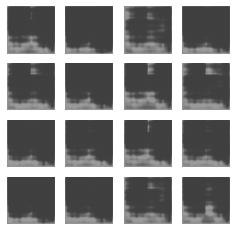

Epoch 20 : [D loss: 0.000004, acc.: 100.00%] [G loss: 0.000000]


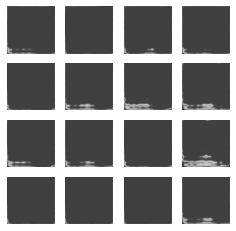

Epoch 30 : [D loss: 0.000002, acc.: 100.00%] [G loss: 0.000333]


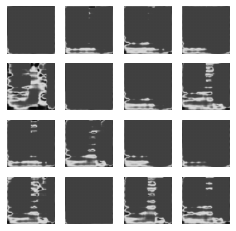

Epoch 40 : [D loss: 0.000035, acc.: 100.00%] [G loss: 0.002676]


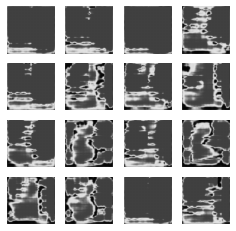

Epoch 50 : [D loss: 0.000062, acc.: 100.00%] [G loss: 0.000000]


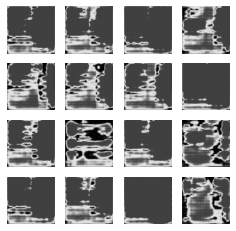

Epoch 60 : [D loss: 26.961731, acc.: 44.00%] [G loss: 19.576500]


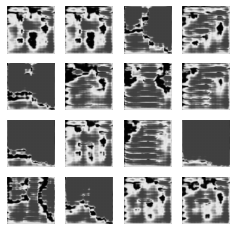

Epoch 70 : [D loss: 0.013113, acc.: 99.50%] [G loss: 0.000000]


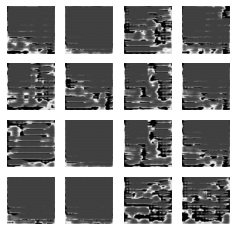

Epoch 80 : [D loss: 0.003349, acc.: 99.75%] [G loss: 0.000000]


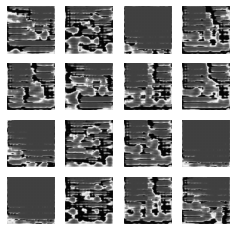

Epoch 90 : [D loss: 0.002821, acc.: 100.00%] [G loss: 0.000000]


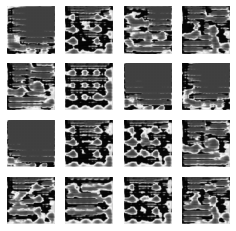

Epoch 100 : [D loss: 0.000038, acc.: 100.00%] [G loss: 0.000000]


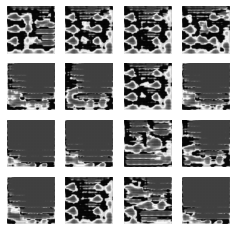

Epoch 110 : [D loss: 0.000630, acc.: 100.00%] [G loss: 0.000000]


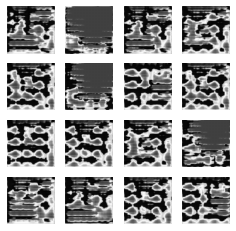

Epoch 120 : [D loss: 0.000141, acc.: 100.00%] [G loss: 0.000008]


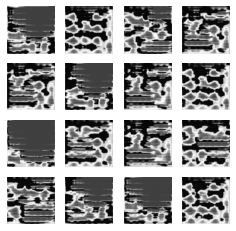

Epoch 130 : [D loss: 0.000495, acc.: 100.00%] [G loss: 0.000001]


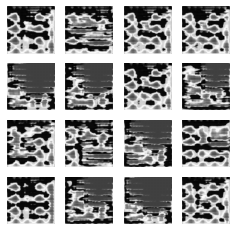

Epoch 140 : [D loss: 0.007705, acc.: 99.50%] [G loss: 0.051255]


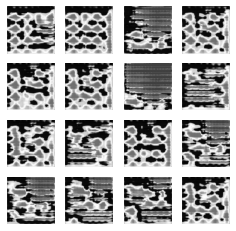

Epoch 150 : [D loss: 0.027145, acc.: 99.50%] [G loss: 0.556582]


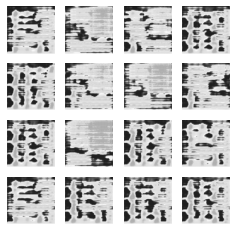

Epoch 160 : [D loss: 0.003340, acc.: 99.75%] [G loss: 16.747890]


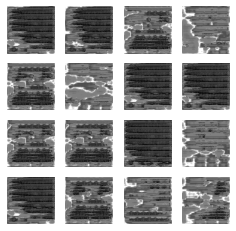

Epoch 170 : [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000550]


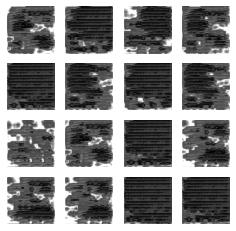

Epoch 180 : [D loss: 0.000000, acc.: 100.00%] [G loss: 0.148907]


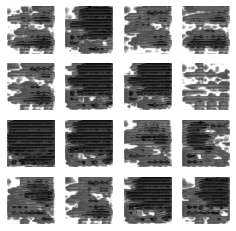

Epoch 190 : [D loss: 0.000000, acc.: 100.00%] [G loss: 0.084582]


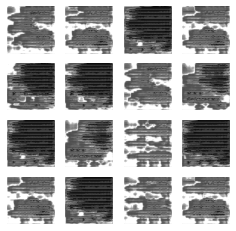

Epoch 200 : [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000001]


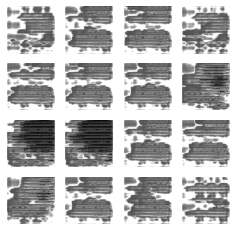

Epoch 210 : [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000007]


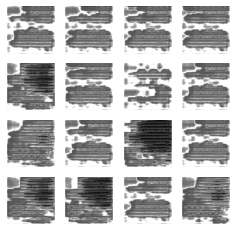

Epoch 220 : [D loss: 0.000001, acc.: 100.00%] [G loss: 0.002267]


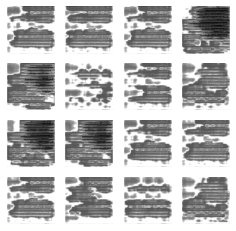

Epoch 230 : [D loss: 0.000000, acc.: 100.00%] [G loss: 0.005015]


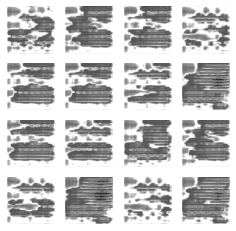

Epoch 240 : [D loss: 0.000046, acc.: 100.00%] [G loss: 0.016621]


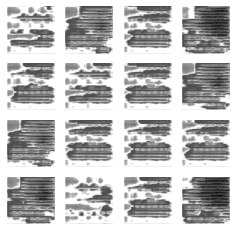

Epoch 250 : [D loss: 0.000534, acc.: 100.00%] [G loss: 1.446239]


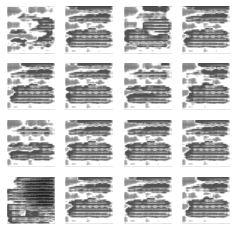

Epoch 260 : [D loss: 0.000000, acc.: 100.00%] [G loss: 0.123814]


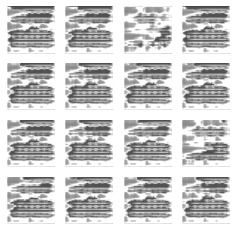

Epoch 270 : [D loss: 0.000000, acc.: 100.00%] [G loss: 0.238283]


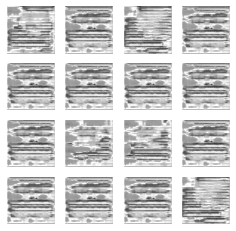

Epoch 280 : [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000001]


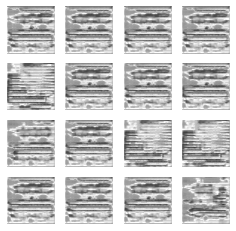

Epoch 290 : [D loss: 0.001196, acc.: 100.00%] [G loss: 41.477379]


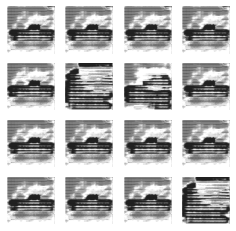

Epoch 300 : [D loss: 0.000093, acc.: 100.00%] [G loss: 0.046627]


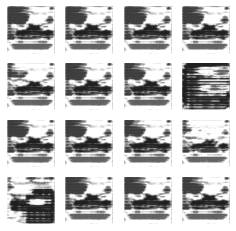

Epoch 310 : [D loss: 0.000007, acc.: 100.00%] [G loss: 0.006679]


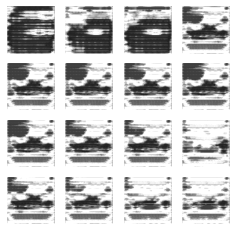

Epoch 320 : [D loss: 0.000550, acc.: 100.00%] [G loss: 0.012593]


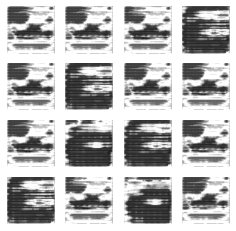

Epoch 330 : [D loss: 0.000036, acc.: 100.00%] [G loss: 0.004355]


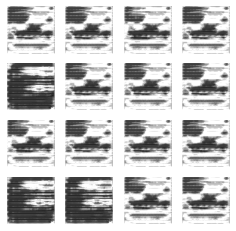

Epoch 340 : [D loss: 0.000009, acc.: 100.00%] [G loss: 0.018782]


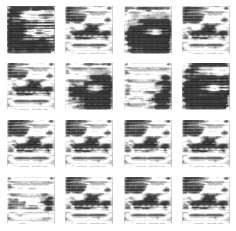

Epoch 350 : [D loss: 0.000035, acc.: 100.00%] [G loss: 0.026736]


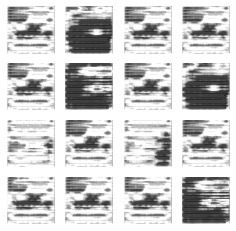

Epoch 360 : [D loss: 0.000012, acc.: 100.00%] [G loss: 0.061453]


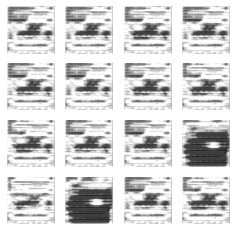

Epoch 370 : [D loss: 0.000019, acc.: 100.00%] [G loss: 0.012567]


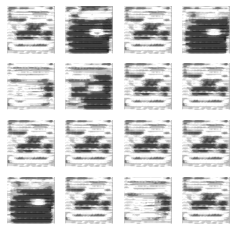

Epoch 380 : [D loss: 0.000007, acc.: 100.00%] [G loss: 0.003871]


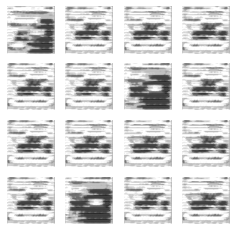

Epoch 390 : [D loss: 0.000013, acc.: 100.00%] [G loss: 0.152568]


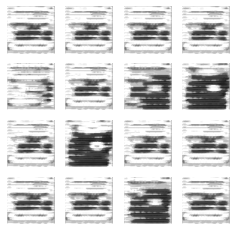

Epoch 400 : [D loss: 0.000020, acc.: 100.00%] [G loss: 0.000255]


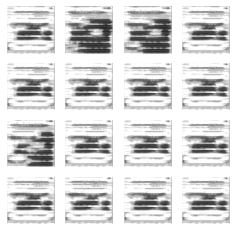

In [9]:
# Set hyperparameters
iterations = 400
batch_size = 200
sample_interval = 10

# Train the DCGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

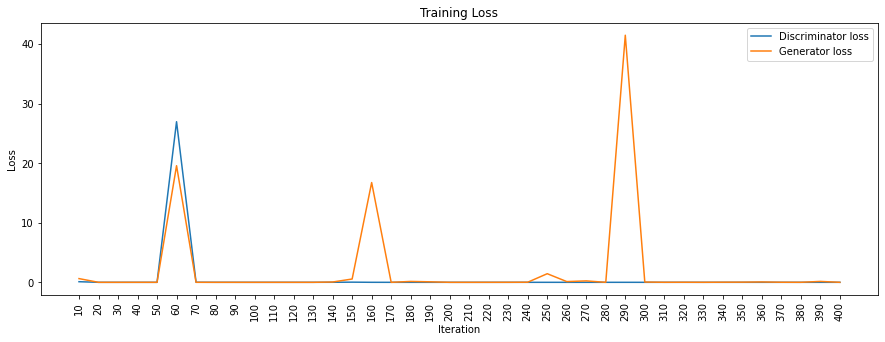

In [10]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

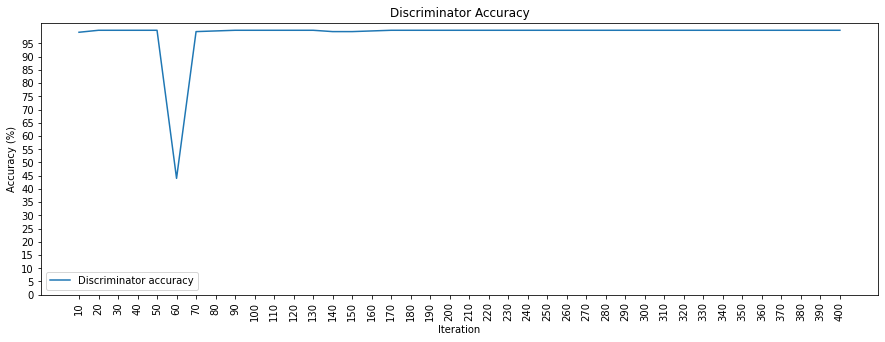

In [11]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()